# Training CNN for imaging fluid flow with streaks analysis
    

## Prepatory steps

Get some includes first and define convenience routines

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from numpy import random
import sys

%matplotlib inline

print(torch.__version__)

1.0.1.post2


Fix random seed to make sure we get reproducible results. This can be removed at production stage.

In [2]:
my_seed = 12345
torch.manual_seed(my_seed)

Load data and preprocess

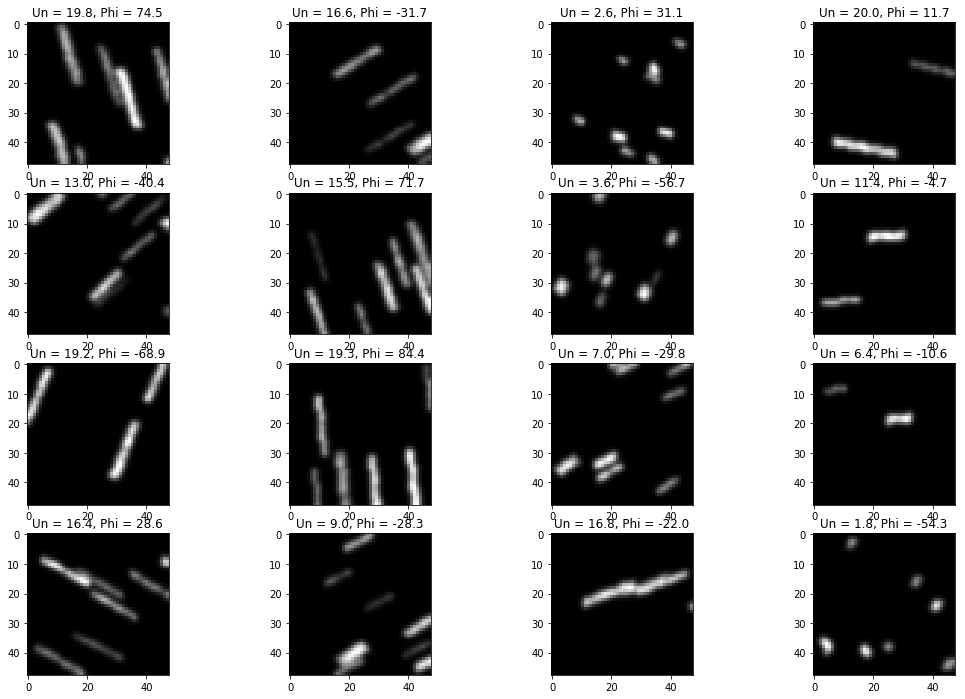

In [3]:
h5f = h5py.File('data/train_val_sets_grayscale_gradient_uniformDisp_n=1M.h5','r')

images = h5f['images'][()]
Un = h5f['Un'][()]
Phi = h5f['Phi'][()]
windowSize = h5f['windowSize'][()]

h5f.close()

trainImages, validationImages, trainData, validationData = \
    train_test_split(images, np.column_stack((Un, Phi)), test_size=0.25, random_state=my_seed, shuffle = False)

images = []

indices = random.randint(0, len(trainImages), 16)

fig = plt.figure()
for i in range(indices.size):
    ax = fig.add_subplot(4, 4, i + 1)
    plt.gray()
    plt.imshow(trainImages[indices[i],0,:,:])
    ax.set_title("Un = %.1f, Phi = %.1f" % (trainData[indices[i],0], trainData[indices[i],1]))
    
fig.set_size_inches(np.array(fig.get_size_inches()) * 3)
plt.show()

Preprocess data

((750000, 2), (250000, 2))


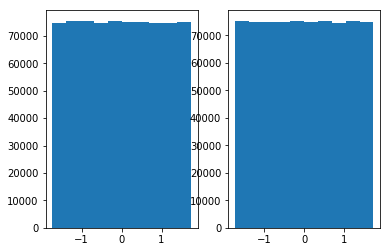

In [4]:
scaler = StandardScaler()
trainDataUnit = scaler.fit_transform(trainData)
validationDataUnit = scaler.transform(validationData)

print((trainDataUnit.shape, validationDataUnit.shape))

fig = plt.figure()
ax = fig.add_subplot(1,2,1)
plt.hist(trainDataUnit[:,0]);
ax = fig.add_subplot(1,2,2)
plt.hist(trainDataUnit[:,1]);

## Creating and training of a CNN

Define some global settings

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


Load network architecture we will use

In [6]:
from CNN_architectures import StreaksCNN

Convert data into pytorch compatible format

In [7]:
params = {'batch_size': 192,
          'shuffle': True,
          'num_workers': 0}

xtrain = torch.from_numpy(trainImages / 255.).type(torch.FloatTensor)
ytrain = torch.from_numpy(trainDataUnit).type(torch.FloatTensor)

train_dataset = TensorDataset(xtrain, ytrain)
train_loader = DataLoader(train_dataset, **params)

#for batch_idx, (x, y) in enumerate(train_loader):
#    print(x.shape, y.shape)

xvalidation = torch.from_numpy(validationImages / 255.).type(torch.FloatTensor)
yvalidation = torch.from_numpy(validationDataUnit).type(torch.FloatTensor)

validation_dataset = TensorDataset(xvalidation, yvalidation)
validation_loader = DataLoader(validation_dataset, **params)

print(len(train_dataset), len(validation_dataset))

750000 250000


Perform ensemble training

In [8]:
n_ensemble_members = 10
net_ensemble = []

filter_size = 5
padding = 2

learning_rate = 1e-3
n_epochs = 100
n_batches = len(train_loader)

train_loss_log = np.zeros((n_ensemble_members, n_epochs))
validation_loss_log = np.zeros((n_ensemble_members, n_epochs))

# Time for printing
training_start_time = time.time()
for n in range(n_ensemble_members):
    net = StreaksCNN(winSz = windowSize, filtSz = filter_size, convPad = padding)
    net.to(device)
    loss = torch.nn.SmoothL1Loss(reduction='sum')
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', \
                                                     factor = 0.5, patience = 7, \
                                                     min_lr = 1e-6, verbose = True, \
                                                     threshold = 1e-3)

    # Loop for n_epochs
    for epoch in range(n_epochs):        
        net.train()
        for i, data in enumerate(train_loader, 0):
            # Get inputs
            inputs, outputs = data
            
            # Send them to GPU
            inputs, outputs = inputs.to(device), outputs.to(device)
                
            # Set the parameter gradients to zero
            optimizer.zero_grad()
            
            # Forward pass, backward pass, optimize
            net_outputs = net(inputs)
        
            loss_size = loss(net_outputs, outputs)
            loss_size.backward()
            optimizer.step()

        # At the end of the epoch, do a pass on the training set to get true loss
        net.eval()
        total_train_loss = 0
        for inputs, outputs in train_loader:
            # Send to device
            inputs, outputs = inputs.to(device), outputs.to(device)

            # Forward pass
            net_outputs = net(inputs)
            net_loss_size = loss(net_outputs, outputs)
            total_train_loss += net_loss_size.item()
        
        # At the end of the epoch, do a pass on the validation set
        net.eval()
        total_val_loss = 0
        for inputs, outputs in validation_loader:
            # Send to device
            inputs, outputs = inputs.to(device), outputs.to(device)

            # Forward pass
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, outputs)
            total_val_loss += val_loss_size.item()
        
        scheduler.step(total_val_loss)
        sys.stdout.flush()
    
        train_loss_log[n][epoch] = np.sqrt(total_train_loss / len(train_dataset))
        validation_loss_log[n][epoch] = np.sqrt(total_val_loss / len(validation_dataset))
    
        if(epoch % 10 == 0):
            print("#{:}: Epoch {:}. Train RMSE = {:.4f}, Validation RMSE = {:.4f}".format(n, epoch, train_loss_log[n][epoch], validation_loss_log[n][epoch]))
        
    net_ensemble.append(net)

print("Training finished, took {:.1f}s".format(time.time() - training_start_time))

#0: Epoch 0. Train RMSE = 0.2625, Validation RMSE = 0.2648
#0: Epoch 10. Train RMSE = 0.1916, Validation RMSE = 0.1956
#0: Epoch 20. Train RMSE = 0.1899, Validation RMSE = 0.1950
Epoch    29: reducing learning rate of group 0 to 5.0000e-04.
#0: Epoch 30. Train RMSE = 0.1694, Validation RMSE = 0.1762
#0: Epoch 40. Train RMSE = 0.1704, Validation RMSE = 0.1777
Epoch    43: reducing learning rate of group 0 to 2.5000e-04.
#0: Epoch 50. Train RMSE = 0.1625, Validation RMSE = 0.1715
#0: Epoch 60. Train RMSE = 0.1632, Validation RMSE = 0.1723
Epoch    61: reducing learning rate of group 0 to 1.2500e-04.
#0: Epoch 70. Train RMSE = 0.1602, Validation RMSE = 0.1702
Epoch    74: reducing learning rate of group 0 to 6.2500e-05.
#0: Epoch 80. Train RMSE = 0.1602, Validation RMSE = 0.1702
Epoch    89: reducing learning rate of group 0 to 3.1250e-05.
#0: Epoch 90. Train RMSE = 0.1591, Validation RMSE = 0.1696
Epoch    97: reducing learning rate of group 0 to 1.5625e-05.
#1: Epoch 0. Train RMSE = 0.3

Once the networks are trained, let us display some learning statistics and model information

Text(0, 0.5, 'RMSE')

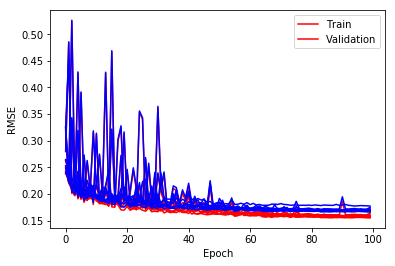

In [9]:
fig = plt.figure()
plt.plot(train_loss_log[:].transpose(), 'r')
plt.plot(validation_loss_log[:].transpose(), 'b')
plt.legend(('Train', 'Validation'))
plt.xlabel('Epoch')
plt.ylabel('RMSE')

Print model summary

In [10]:
print(net_ensemble[0])

StreaksCNN(
  (cnn_part): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): ReLU()
    (10): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (13): ReLU()
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout2d(p=0.3)
  (fc1): Linear(in_features=1152, out_feat

Apply final network ensemble to the validation data set and check accuracy on Un and phi independently

In [11]:
params = {'batch_size': 192,
          'shuffle': False,
          'num_workers': 0}

test_loader = DataLoader(validation_dataset, **params)

thrNorm = 2;
thrPhi = 18; 

for n in range(n_ensemble_members):
    net = net_ensemble[n]
    net.eval()
    
    ypredicted = np.empty(shape=(0,2))
    for inputs, _ in test_loader:
        # Wrap tensors in Variables
        inputs = inputs.to(device)
            
        # Forward pass
        val_outputs = net(inputs)
    
        if 'cuda' in device.type:
            val_outputs = val_outputs.cpu()
    
        ypredicted = np.concatenate((ypredicted, val_outputs.data.numpy()))
    
    ypredicted = scaler.inverse_transform(ypredicted)
    yresiduals = ypredicted - validationData
    yrmse = np.sqrt(np.mean(yresiduals**2, axis = 0))
    
    numCorrectNorm = np.sum(np.abs(yresiduals[:,0]) < thrNorm)
    numCorrectPhi = np.sum(np.abs(yresiduals[:,1]) < thrPhi)
    accuracy = np.array([numCorrectNorm, numCorrectPhi])/len(yresiduals)

    print(n, 'RMSE on Un = ', yrmse[0], ', RMSE on phi = ', yrmse[1], ', Accruacy:', accuracy)

0 RMSE on Un =  1.1470082887087445 , RMSE on phi =  9.381223825966906 , Accruacy: [0.94252  0.969372]
1 RMSE on Un =  1.10806065578509 , RMSE on phi =  9.191139726531961 , Accruacy: [0.94736  0.971288]
2 RMSE on Un =  1.1993557703921098 , RMSE on phi =  9.452942463540946 , Accruacy: [0.933448 0.968164]
3 RMSE on Un =  1.1660121223125597 , RMSE on phi =  9.549979063964274 , Accruacy: [0.939536 0.968944]
4 RMSE on Un =  1.1393155220645008 , RMSE on phi =  9.338877540000636 , Accruacy: [0.943188 0.972228]
5 RMSE on Un =  1.1143167464209307 , RMSE on phi =  9.055128098245746 , Accruacy: [0.946684 0.971584]
6 RMSE on Un =  1.1473084937126787 , RMSE on phi =  9.05385994516575 , Accruacy: [0.941808 0.97156 ]
7 RMSE on Un =  1.1223896863706695 , RMSE on phi =  9.169347369288356 , Accruacy: [0.94558 0.97174]
8 RMSE on Un =  1.1411203054799328 , RMSE on phi =  9.186732218473312 , Accruacy: [0.94236  0.970028]
9 RMSE on Un =  1.1249191768942604 , RMSE on phi =  9.103469128940565 , Accruacy: [0.94

Save trained networks and all additional training data

In [12]:
file_net = 'network_grayscale_gradient_uniformDisp_n=1M'

for n in range(n_ensemble_members):
    f_output_name = 'networks/%s_%d.pytorch' % (file_net, n)
    torch.save(net_ensemble[n].state_dict(), f_output_name)

h5f = h5py.File(('networks/%s_data.h5' % file_net), 'w')
h5f.create_dataset('n_ensemble_members', data=n_ensemble_members)
h5f.create_dataset('RMSE', data=yrmse, compression="gzip", compression_opts=6)
#h5f.create_dataset('trainImages', data=trainImages, compression="gzip", compression_opts=6)
h5f.create_dataset('validationImages', data=validationImages, compression="gzip", compression_opts=6)
#h5f.create_dataset('trainData', data=trainData, compression="gzip", compression_opts=6)
h5f.create_dataset('validationData', data=validationData, compression="gzip", compression_opts=6)
h5f.create_dataset('scale', data=scaler.scale_)
h5f.create_dataset('mean', data=scaler.mean_)
h5f.create_dataset('rmse_training', data=train_loss_log)
h5f.create_dataset('rmse_validation', data=validation_loss_log)
h5f.create_dataset('windowSize', data=windowSize)
h5f.create_dataset('filter_size', data=filter_size)
h5f.create_dataset('padding', data=padding)

h5f.close()